In [4]:
"""WSTM --Homework-3--"""
"""Saumya Dwivedi (sdwivedi30)"""

'Saumya Dwivedi (sdwivedi30)'

In [6]:
%matplotlib inline

In [7]:
""" Q.1 Implement Oasis Algorithm"""
### This has been done in the function oasis and oasis_batch(which processes a bunch of iterations, in this case 1000)
### Oasis function takes in the training and test data, is_psd/is_sym check if the matrix has to be PSD/symmetric
### The initial W(weight) matrix is taken to be identity matrix with dim = num of words in vocabulary, hence
### has positive eigen values throughout.

""" Q.2 Create data triplets"""
### Data from kos file is processed through pandas library functions.
### Pearson correlation is used to form triplets (p, p+, p-) such that PC(p, p+) > PC(p, p-). Created 3430*10 triplets.
### The triplets dataset was then randomly distributed into test(20%) and training set.
### Objective function+training error+test error is calculated after every 1000 iterations(in calculate_global_loss()).
### All the loss functions are errors then plotted using functions (plot_*)
### We see from the console output, as well as the graph, that the loss function decreases as iterations progress.

### [''TODO'']Running the below cell might take some time, although least as compared to Q.3/Q.4
### since no symmetric operations performed on the updated W.

### I use a sparse representation of the matrices, which allows to compute similarities very fast.


' Q.2 Create data triplets'

Total iterations  27440
Total number of batches =  28  with iteration steps =  1000
Run batch  1 / 28  for  1000  iterations.
For this batch: Global loss= 24384.5012184  Training Error= 17.9555393586 %. Test error= 18.7463556851 %.
Run batch  2 / 28  for  1000  iterations.
For this batch: Global loss= 18898.5707717  Training Error= 16.8476676385 %. Test error= 18.1486880466 %.
Run batch  3 / 28  for  1000  iterations.
For this batch: Global loss= 16652.1135204  Training Error= 16.1005830904 %. Test error= 17.7551020408 %.
Run batch  4 / 28  for  1000  iterations.
For this batch: Global loss= 14891.4744397  Training Error= 15.6596209913 %. Test error= 17.5364431487 %.
Run batch  5 / 28  for  1000  iterations.
For this batch: Global loss= 13385.2649179  Training Error= 15.3097667638 %. Test error= 17.2886297376 %.
Run batch  6 / 28  for  1000  iterations.
For this batch: Global loss= 12605.5360153  Training Error= 15.4482507289 %. Test error= 17.6530612245 %.
Run batch  7 / 28  for  1000

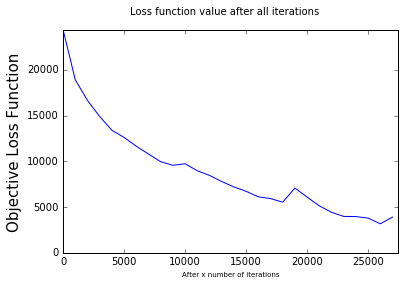

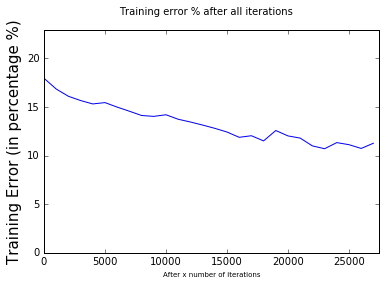

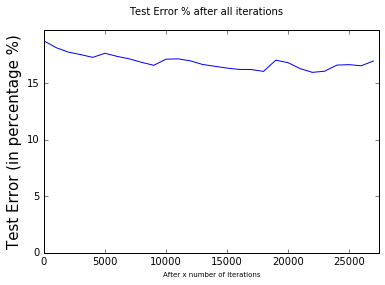

In [13]:
import pandas
import numpy as np
from scipy.stats.stats import pearsonr
import random
from scipy import sparse
import itertools
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from scipy.sparse.linalg.eigen.arpack import eigsh
from numpy.linalg import matrix_rank
from scipy.linalg import sqrtm
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
import warnings
 
filename='docword.kos.txt'
csv_delimiter = ' '
data=np.zeros((3430, 6906), dtype=np.int)
triplets=np.zeros((3430*10, 3), dtype=np.int)
N = 3430
dim = 6906
iter_index = []

def open_file_and_load_data():
    fields = ['docid', 'wordid', 'count']
    df = pandas.read_csv(filename, sep=csv_delimiter, names=fields)
    dataSer = df.values
    for ir in dataSer[3:]:
        data[int(ir[0])-1][int(ir[1])-1] += int(ir[2])        

def create_triplets():
    global N, dim
    count_triplet = 0
    for p in xrange(1,N+1):
        r_points = random.sample([x for x in xrange(1,N+1) if x != p], 5)
        for pair in iter_index:
            p_plus_ind, p_neg_ind = r_points[pair[0]], r_points[pair[1]]
            possible_plus = pearsonCorrelation(data[p_plus_ind-1], data[p-1])
            possible_minus = pearsonCorrelation(data[p_neg_ind-1], data[p-1])
            if (possible_minus > possible_plus):
                p_plus_ind, p_neg_ind = p_neg_ind, p_plus_ind
            triplets[count_triplet] = [p, p_plus_ind, p_neg_ind]
            count_triplet += 1

def pearsonCorrelation(vector1, vector2):
    ## much faster to use vectors
    return pearsonr(vector1, vector2)[0]
 
def plot_objective_function(loss_func_g, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = loss_func_g
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Loss function value after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Objective Loss Function',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(loss_func_g)+1)
    plt.show()

def plot_training_error(tre, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = tre
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Training error % after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Training Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(tre)+5)
    plt.show()

def plot_test_error(te, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = te
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Test Error % after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Test Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(te)+1)
    plt.show()
    
def oasis_batch(W, train_data, iteration_step=10, aggress=0.1):
    global N, dim
    l = len(train_data)
    W_spr = sparse.csr_matrix(W)
    for step in xrange(min(iteration_step, l)):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[step]

        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0] 
        #print "Loss value.. ", loss
        if (loss > 0):
            W_updated = p_spr.T * (p_delta_spr) 
            norm_grad_W = (p_spr.dot(p_spr.T)) * (p_delta_spr.dot(p_delta_spr.T))
            norm_grad_W = norm_grad_W.toarray()[0][0]
            tau_val = loss/norm_grad_W; #loss / (V*V');
        #    print "Tau value is... ", tau_val
            tau = min(aggress, tau_val)
            W_spr = W_spr + tau * W_updated
    return W_spr.toarray()

def calculate_global_loss(W, train_data, test_data):
    #Training data
    train_dataset_num = train_data.shape[0]
    test_dataset_num = test_data.shape[0]
    W_spr = sparse.csr_matrix(W)
    loss_func = 0.0
    train_class_miss = 0.0
    test_class_miss = 0.0
    for i in xrange(train_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        loss_func += loss
        if loss > 0:
            train_class_miss += 1

    for i in xrange(test_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = test_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        if loss > 0:
            test_class_miss += 1

    return [loss_func, train_class_miss*100/train_dataset_num, test_class_miss*100/test_dataset_num]

def make_W_neg_eigen(W):
    for x in xrange(0, 1000, 50):
        W[x] = -1 * W[x]
    return W

def oasis(train_data, test_data, num_iterations=100, iteration_step=10, is_sym=False, is_psd=False):

    global dim
    # initialize W
    W = np.identity(dim)
    # want to have negative eigen values?
#    W = make_W_neg_eigen(W)
    
    print "Total iterations ", num_iterations
    loss_steps = np.zeros(num_iterations)
    num_batches = int(np.ceil(num_iterations / iteration_step))
    num_batches = num_batches + 1 if num_batches*iteration_step < num_iterations else num_batches
    print "Total number of batches = " , num_batches, " with iteration steps = ", iteration_step
    #num_batches = 2
    loss_func_g = []
    train_g = []
    test_g = []
    for batch in xrange(num_batches):
        print 'Run batch ', batch+1, '/', num_batches,' for ', iteration_step, ' iterations.'
        W = oasis_batch(W, train_data[batch*iteration_step:], iteration_step, 0.1)
        [lf, tre, te] = calculate_global_loss(W, train_data, test_data)
        loss_func_g.append(lf)
        train_g.append(tre)
        test_g.append(te)
        print 'For this batch: Global loss=', lf, ' Training Error=', tre, '%. Test error=', te, '%.'
    #print len(tre)
    plot_objective_function(loss_func_g, num_iterations, iteration_step)
    plot_training_error(train_g, num_iterations, iteration_step)
    plot_test_error(test_g, num_iterations, iteration_step)
    return W
    
def main():
    global iter_index
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    iter_index = list(itertools.combinations(range(5), 2))
    open_file_and_load_data()
    create_triplets()
    train_data, test_data = train_test_split(triplets, test_size = 0.2)
    train_dataset_num = train_data.shape[0]
    W_model = oasis(train_data, test_data, train_dataset_num, 1000)

if __name__ == "__main__":
    main()

In [10]:
""" Q.3 Enforce the W matrix to be symmetrix with (make_symmetric function)"""
### Training and testing error, loss function plots are embedded below.
""" Eigenvalues """
### Eigenvalues of the computed W matrix is calculated, however it was noted that after every iteration W had only
### positive eigenvalues. This is attributed to the initial matrix W(identity) being a PSD. The eigenvalues are plotted
### for the final model W obtained.

' Eigenvalues '

Total iterations  27440
Total number of batches =  28  with iteration steps =  1000
Run batch  1 / 28  for  1000  iterations.
For this batch: Global loss= 26442.4726064  Training Error= 18.0539358601 %. Test error= 18.8192419825 %.
Run batch  2 / 28  for  1000  iterations.
For this batch: Global loss= 20010.3248195  Training Error= 17.0991253644 %. Test error= 17.7113702624 %.
Run batch  3 / 28  for  1000  iterations.
For this batch: Global loss= 17482.5603909  Training Error= 16.7747813411 %. Test error= 17.2157434402 %.
Run batch  4 / 28  for  1000  iterations.
For this batch: Global loss= 15974.186207  Training Error= 16.5415451895 %. Test error= 16.9533527697 %.
Run batch  5 / 28  for  1000  iterations.
For this batch: Global loss= 14966.8364904  Training Error= 16.5051020408 %. Test error= 16.8950437318 %.
Run batch  6 / 28  for  1000  iterations.
For this batch: Global loss= 15139.5131375  Training Error= 17.2704081633 %. Test error= 17.5364431487 %.
Run batch  7 / 28  for  1000 

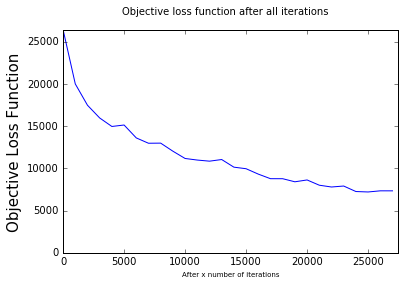

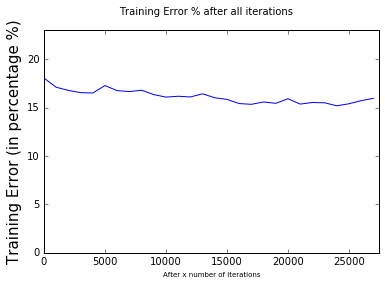

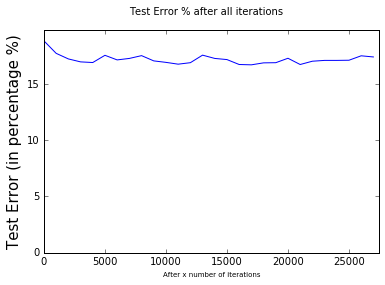

Calculating all the real (pos/neg) eigenvalues of W...


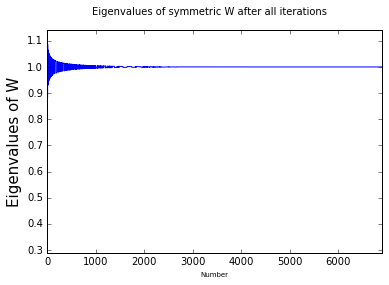

In [22]:
import pandas
import numpy as np
from scipy.stats.stats import pearsonr
import random
from scipy import sparse
import itertools
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
from numpy.linalg import matrix_rank
from scipy.linalg import sqrtm
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
import warnings
 
filename='docword.kos.txt'
csv_delimiter = ' '
data=np.zeros((3430, 6906), dtype=np.int)
triplets=np.zeros((3430*10, 3), dtype=np.int)
N = 3430
dim = 6906
iter_index = []

def open_file_and_load_data():
    fields = ['docid', 'wordid', 'count']
    df = pandas.read_csv(filename, sep=csv_delimiter, names=fields)
    dataSer = df.values
    for ir in dataSer[3:]:
        data[int(ir[0])-1][int(ir[1])-1] += int(ir[2])        

def create_triplets():
    global N, dim
    count_triplet = 0
    for p in xrange(1,N+1):
        r_points = random.sample([x for x in xrange(1,N+1) if x != p], 5)
        for pair in iter_index:
            p_plus_ind, p_neg_ind = r_points[pair[0]], r_points[pair[1]]
            possible_plus = pearsonCorrelation(data[p_plus_ind-1], data[p-1])
            possible_minus = pearsonCorrelation(data[p_neg_ind-1], data[p-1])
            if (possible_minus > possible_plus):
                p_plus_ind, p_neg_ind = p_neg_ind, p_plus_ind
            triplets[count_triplet] = [p, p_plus_ind, p_neg_ind]
            count_triplet += 1

def make_symmetric(W):
    W_spr = sparse.csr_matrix(W)
    return (0.5 * (W_spr + W_spr.T)).toarray()

def pearsonCorrelation(vector1, vector2):
    ## much faster to use vectors
    return pearsonr(vector1, vector2)[0]

def plot_eigenvalues(eg):
    X = range(1, len(eg)+1, 1)
    Y = list(eg)
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Eigenvalues of symmetric W after all iterations')
    plt.xlabel('Number',fontsize=7)
    plt.ylabel('Eigenvalues of W',fontsize=15)
    plt.grid(False)
    plt.xlim(0,len(eg)+1)
    plt.ylim(min(eg)-0.0005,max(eg)+0.0005)
    plt.show()
    
def plot_objective_function(loss_func_g, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = loss_func_g
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Objective loss function after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Objective Loss Function',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(loss_func_g)+1)
    plt.show()
    
def plot_training_error(tre, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = tre
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Training Error % after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Training Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(tre)+5)
    plt.show()

def plot_test_error(te, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = te
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Test Error % after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Test Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(te)+1)
    plt.show()
    
def oasis_batch(W, train_data, iteration_step=10, aggress=0.1):
    global N, dim
    l = len(train_data)
    W_spr = sparse.csr_matrix(W)
    for step in xrange(min(iteration_step, l)):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[step]

        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0] 
        #print "Loss value.. ", loss
        if (loss > 0):
            W_updated = p_spr.T * (p_delta_spr) 
            norm_grad_W = (p_spr.dot(p_spr.T)) * (p_delta_spr.dot(p_delta_spr.T))
            norm_grad_W = norm_grad_W.toarray()[0][0]
            tau_val = loss/norm_grad_W; #loss / (V*V');
        #    print "Tau value is... ", tau_val
            tau = min(aggress, tau_val)
            W_spr = W_spr + tau * W_updated
    return W_spr.toarray()

def calculate_global_loss(W, train_data, test_data):
    #Training data
    train_dataset_num = train_data.shape[0]
    test_dataset_num = test_data.shape[0]
    W_spr = sparse.csr_matrix(W)
    loss_func = 0.0
    train_class_miss = 0.0
    test_class_miss = 0.0
    for i in xrange(train_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        loss_func += loss
        if loss > 0:
            train_class_miss += 1

    for i in xrange(test_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = test_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        if loss > 0:
            test_class_miss += 1

    return [loss_func, train_class_miss*100/train_dataset_num, test_class_miss*100/test_dataset_num]

def oasis(train_data, test_data, num_iterations=100, iteration_step=10, is_sym=False, is_psd=False):

    global dim
    # initialize W
    W = np.identity(dim)
    
    print "Total iterations ", num_iterations
    loss_steps = np.zeros(num_iterations)
    num_batches = int(np.ceil(num_iterations / iteration_step))
    num_batches = num_batches + 1 if num_batches*iteration_step < num_iterations else num_batches
    print "Total number of batches = " , num_batches, " with iteration steps = ", iteration_step
    #num_batches = 2
    loss_func_g = []
    train_g = []
    test_g = []
    for batch in xrange(num_batches):
        print 'Run batch ', batch+1, '/', num_batches,' for ', iteration_step, ' iterations.'
        W = oasis_batch(W, train_data[batch*iteration_step:], iteration_step, 0.1)
        [lf, tre, te] = calculate_global_loss(W, train_data, test_data)
        loss_func_g.append(lf)
        train_g.append(tre)
        test_g.append(te)
        print 'For this batch: Global loss=', lf, ' Training Error=', tre, '%. Test error=', te, '%.'
        if is_sym:
            #symmetric W
            W = make_symmetric(W)    

    plot_objective_function(loss_func_g, num_iterations, iteration_step)
    plot_training_error(train_g, num_iterations, iteration_step)
    plot_test_error(test_g, num_iterations, iteration_step)
    if (is_sym):
        print "Calculating all the real (pos/neg) eigenvalues of W..."
        eig = eigvals(W)
        plot_eigenvalues(eig)
    return W
    
def main():
    global iter_index
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    iter_index = list(itertools.combinations(range(5), 2))
    open_file_and_load_data()
    create_triplets()
    train_data, test_data = train_test_split(triplets, test_size = 0.2)
    train_dataset_num = train_data.shape[0]
    W_model = oasis(train_data, test_data, train_dataset_num, 1000, True, False)
    

    #print W_model

if __name__ == "__main__":
    main()

In [19]:
""" Q.3 Significance of Negative Eigenvalues"""
### :Initialize W = matrix with neg. eigenvalues to experiment on the behavior of the model"""
### W is initialized using make_W_neg_eigen
### However we observe that the training and testing errors remain almost the same and decrease consistently 
### initializing with a negative 
### eigenvalue W. Negative eigenvalues with insignificant magnitudes indicate a less serious model misspecification.
### Typically, it just indicates the use of too many variables that are highly correlated. In this case, the model
### naturally converges towards a PSD.

### Negative eigenvalues correspond to non-oscillatory, exponentially stable modes / solutions.
### So if the initial condition vector of a system corresponds to a negative eigenvalue, 
### the state of the system will decay to 0 like an exponential without oscillating.

### PSD matrix have the property of having only positive eigenvalues. They are often used in similarity learning
### algorithms to provide a context of ranking and reduce over fitting. 
### When the amount of training data available is very small, adding positivity constraints for enforcing metric 
### properties is useful for reducing over fitting and improving generalization. 
### However, when sufficient data is available, adding positive semidefinitiveness constraints 
### consumes considerable computation time(as you would see in the last part of the hw), and its benefit in terms of 
### generalization are limited.



' Q.3 Significance of Negative Eigenvalues'

Total iterations  27440
Total number of batches =  28  with iteration steps =  1000
Run batch  1 / 28  for  1000  iterations.
For this batch: Global loss= 25894.392704  Training Error= 18.0903790087 %. Test error= 18.4256559767 %.
Run batch  2 / 28  for  1000  iterations.
For this batch: Global loss= 20229.6839576  Training Error= 17.2084548105 %. Test error= 17.6239067055 %.
Run batch  3 / 28  for  1000  iterations.
For this batch: Global loss= 17337.5587919  Training Error= 17.0881924198 %. Test error= 17.3760932945 %.
Run batch  4 / 28  for  1000  iterations.
For this batch: Global loss= 16059.8641069  Training Error= 16.6508746356 %. Test error= 16.9387755102 %.
Run batch  5 / 28  for  1000  iterations.
For this batch: Global loss= 15985.0373747  Training Error= 17.4198250729 %. Test error= 17.7113702624 %.
Run batch  6 / 28  for  1000  iterations.
For this batch: Global loss= 15611.2775068  Training Error= 17.5036443149 %. Test error= 17.7988338192 %.
Run batch  7 / 28  for  1000 

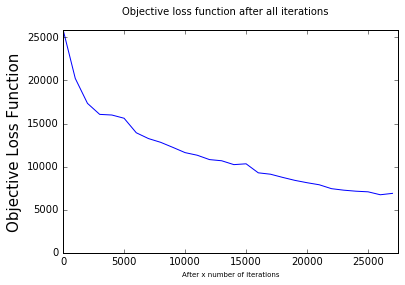

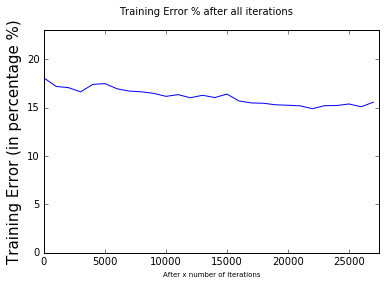

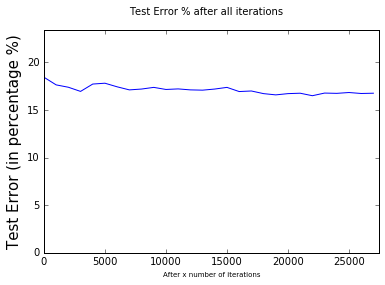

Calculating all the real (pos/neg) eigenvalues of W...


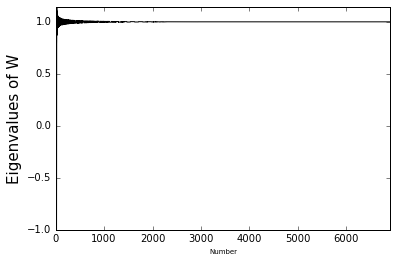

In [24]:
import pandas
import numpy as np
from scipy.stats.stats import pearsonr
import random
from scipy import sparse
import itertools
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
from numpy.linalg import matrix_rank
from scipy.linalg import sqrtm
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
import warnings
 
filename='docword.kos.txt'
csv_delimiter = ' '
data=np.zeros((3430, 6906), dtype=np.int)
triplets=np.zeros((3430*10, 3), dtype=np.int)
N = 3430
dim = 6906
iter_index = []

def open_file_and_load_data():
    fields = ['docid', 'wordid', 'count']
    df = pandas.read_csv(filename, sep=csv_delimiter, names=fields)
    dataSer = df.values
    for ir in dataSer[3:]:
        data[int(ir[0])-1][int(ir[1])-1] += int(ir[2])        

def create_triplets():
    global N, dim
    count_triplet = 0
    for p in xrange(1,N+1):
        r_points = random.sample([x for x in xrange(1,N+1) if x != p], 5)
        for pair in iter_index:
            p_plus_ind, p_neg_ind = r_points[pair[0]], r_points[pair[1]]
            possible_plus = pearsonCorrelation(data[p_plus_ind-1], data[p-1])
            possible_minus = pearsonCorrelation(data[p_neg_ind-1], data[p-1])
            if (possible_minus > possible_plus):
                p_plus_ind, p_neg_ind = p_neg_ind, p_plus_ind
            triplets[count_triplet] = [p, p_plus_ind, p_neg_ind]
            count_triplet += 1

def make_symmetric(W):
    W_spr = sparse.csr_matrix(W)
    return (0.5 * (W_spr + W_spr.T)).toarray()

def pearsonCorrelation(vector1, vector2):
    ## much faster to use vectors
    return pearsonr(vector1, vector2)[0]

def plot_eigenvalues(eg):
    X = range(1, len(eg)+1, 1)
    #X = range(0, len(loss_func_g))
    Y = list(eg)
    plt.plot(X, Y, color='black')
    plt.xlabel('Number',fontsize=7)
    plt.ylabel('Eigenvalues of W',fontsize=15)
    plt.grid(False)
    plt.xlim(0,len(eg)+1)
    plt.ylim(min(eg)-0.0005,max(eg)+0.0005)
    plt.show()
    
def plot_objective_function(loss_func_g, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = loss_func_g
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Objective loss function after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Objective Loss Function',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(loss_func_g)+1)
    plt.show()
    
def plot_training_error(tre, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = tre
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Training Error % after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Training Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(tre)+5)
    plt.show()

def plot_test_error(te, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = te
    plt.plot(X, Y, color='blue')
    plt.suptitle(r'Test Error % after all iterations')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Test Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(te)+5)
    plt.show()
    
def oasis_batch(W, train_data, iteration_step=10, aggress=0.1):
    global N, dim
    l = len(train_data)
    W_spr = sparse.csr_matrix(W)
    for step in xrange(min(iteration_step, l)):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[step]

        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0] 
        #print "Loss value.. ", loss
        if (loss > 0):
            W_updated = p_spr.T * (p_delta_spr) 
            norm_grad_W = (p_spr.dot(p_spr.T)) * (p_delta_spr.dot(p_delta_spr.T))
            norm_grad_W = norm_grad_W.toarray()[0][0]
            tau_val = loss/norm_grad_W; #loss / (V*V');
        #    print "Tau value is... ", tau_val
            tau = min(aggress, tau_val)
            W_spr = W_spr + tau * W_updated
    return W_spr.toarray()

def calculate_global_loss(W, train_data, test_data):
    #Training data
    train_dataset_num = train_data.shape[0]
    test_dataset_num = test_data.shape[0]
    W_spr = sparse.csr_matrix(W)
    loss_func = 0.0
    train_class_miss = 0.0
    test_class_miss = 0.0
    for i in xrange(train_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        loss_func += loss
        if loss > 0:
            train_class_miss += 1

    for i in xrange(test_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = test_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        if loss > 0:
            test_class_miss += 1

    return [loss_func, train_class_miss*100/train_dataset_num, test_class_miss*100/test_dataset_num]

def make_W_neg_eigen(W):
    for x in xrange(0, 1000, 50):
        W[x] = -1 * W[x]
    return W

def oasis(train_data, test_data, num_iterations=100, iteration_step=10, is_sym=False, is_psd=False):

    global dim
    # initialize W
    W = np.identity(dim)
    # want to have negative eigen values?
    W = make_W_neg_eigen(W)
    
    print "Total iterations ", num_iterations
    loss_steps = np.zeros(num_iterations)
    num_batches = int(np.ceil(num_iterations / iteration_step))
    num_batches = num_batches + 1 if num_batches*iteration_step < num_iterations else num_batches
    print "Total number of batches = " , num_batches, " with iteration steps = ", iteration_step
#    num_batches = 3
    loss_func_g = []
    train_g = []
    test_g = []
    for batch in xrange(num_batches):
        print 'Run batch ', batch+1, '/', num_batches,' for ', iteration_step, ' iterations.'
        W = oasis_batch(W, train_data[batch*iteration_step:], iteration_step, 0.1)
        [lf, tre, te] = calculate_global_loss(W, train_data, test_data)
        loss_func_g.append(lf)
        train_g.append(tre)
        test_g.append(te)
        print 'For this batch: Global loss=', lf, ' Training Error=', tre, '%. Test error=', te, '%.'
        if is_sym:
            #symmetric W
            W = make_symmetric(W)    
    plot_objective_function(loss_func_g, num_iterations, iteration_step)
    plot_training_error(train_g, num_iterations, iteration_step)
    plot_test_error(test_g, num_iterations, iteration_step)
    if (is_sym):
        print "Calculating all the real (pos/neg) eigenvalues of W..."
        eig = eigvals(W)
        plot_eigenvalues(eig)
    return W
    
def main():
    global iter_index
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    iter_index = list(itertools.combinations(range(5), 2))
    open_file_and_load_data()
    create_triplets()
    train_data, test_data = train_test_split(triplets, test_size = 0.2)
    train_dataset_num = train_data.shape[0]
    W_model = oasis(train_data, test_data, train_dataset_num, 1000, True, False)
    

    #print W_model

if __name__ == "__main__":
    main()

In [18]:
## In the above results we observe the global loss function, training and testing error with a W with negative eigenvalues.

In [17]:
""" Q.4 Making matrix PSD"""
### Final component, making PSD is added in this segment of the program. The cell evaluates the W model when is_psd is
### passed as true. is_psd already symmetrisizes the matrix.

### The below cell computes W_model, plots the loss function, training and test error(optional: commented plots).
### It then proceeds to find B in W = B(B.T). This can be done for a PSD matrix K = B*(B.T), 
### compute K = V * D * V.T where B = V * sqrt(D) -- implemented in function (find_B_projection_SVD)

### B is assumed to be of rank 5, hence the resultant matrix is approximated to low rank(5) using SVD&gradient descent.
### B matrix represents vectorization of each word in the vocabulary(6903*k size). Nearest neighbors for each word
### is calculated using cosine similarity.
""" Q.4 b Find 10 words where neighbors make sense """
### : find if the neighboring words have atleast one common document. The neighboring words would typically come from 
### the same(one) document atleast once. Since each word has an occurence of atleast 10 times as per the dataset,
### neighboring words have more probability of sticking together in the same document.

### [TODO]: could not execute cell before submission

' Q.4 b Find 10 words where neighbors make sense '

In [16]:
import pandas
import numpy as np
from scipy.stats.stats import pearsonr
import random
from scipy import sparse
import itertools
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
from numpy.linalg import matrix_rank
from scipy.linalg import sqrtm
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
import warnings
 
filename='docword.kos.txt'
csv_delimiter = ' '
data=np.zeros((3430, 6906), dtype=np.int)
triplets=np.zeros((3430*10, 3), dtype=np.int)
N = 3430
dim = 6906
iter_index = []

def open_file_and_load_data():
    fields = ['docid', 'wordid', 'count']
    df = pandas.read_csv(filename, sep=csv_delimiter, names=fields)
    dataSer = df.values
    for ir in dataSer[3:]:
        data[int(ir[0])-1][int(ir[1])-1] += int(ir[2])        

def create_triplets():
    global N, dim
    count_triplet = 0
    for p in xrange(1,N+1):
        r_points = random.sample([x for x in xrange(1,N+1) if x != p], 5)
        for pair in iter_index:
            p_plus_ind, p_neg_ind = r_points[pair[0]], r_points[pair[1]]
            possible_plus = pearsonCorrelation(data[p_plus_ind-1], data[p-1])
            possible_minus = pearsonCorrelation(data[p_neg_ind-1], data[p-1])
            if (possible_minus > possible_plus):
                p_plus_ind, p_neg_ind = p_neg_ind, p_plus_ind
            triplets[count_triplet] = [p, p_plus_ind, p_neg_ind]
            count_triplet += 1

def make_symmetric(W):
    W_spr = sparse.csr_matrix(W)
    return (0.5 * (W_spr + W_spr.T)).toarray()

def make_psd(W):
    #Make matrix positive definite.
    vals, vec = np.linalg.eigh(0.5 * (W + W.T))  # eigvec in columns
    D = np.diagflat(np.maximum(vals, 0))
    return np.dot(np.dot(vec, D), vec.T)

def find_B_projection_SVD(W):
    # find the eigenvalues
    vals, vec = np.linalg.eigh(W)
    # Now for a PSD matrix K = B*(B.T), compute K = V * D * V.T where B = V * sqrt(D)
    D = np.diagflat(np.maximum(vals, 0))
    B = np.dot(vec, sqrtm(D))

    # rank approximation from 6903 to 5 using SVD low rank app of matrix
    SVD = np.linalg.svd(B, full_matrices=False)
    u, s, v = SVD
    Ar = np.zeros((len(u), len(v)))
    for i in xrange(5):
        Ar += s[i] * np.outer(u.T[i], v[i])
    return Ar

def pearsonCorrelation(vector1, vector2):
    ## much faster to use vectors
    return pearsonr(vector1, vector2)[0]

def plot_eigenvalues(eg):
    X = range(1, len(eg)+1, 1)
    #X = range(0, len(loss_func_g))
    Y = list(eg)
    plt.plot(X, Y, color='blue')
    plt.xlabel('Number',fontsize=7)
    plt.ylabel('Eigenvalues of W',fontsize=15)
    plt.grid(False)
    plt.xlim(0,len(eg)+1)
    #plt.ylim(0,max(loss_func_g)+1)
    plt.show()
    
def plot_objective_function(loss_func_g, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = loss_func_g
    plt.plot(X, Y, color='blue')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Objective Loss Function',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(loss_func_g)+1)
    plt.show()

def plot_training_error(tre, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = tre
    plt.plot(X, Y, color='blue')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Training Error (in percentage %)',fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(tre)+5)
    plt.show()

def plot_test_error(te, num_iterations, iteration_step):
    X = range(0, num_iterations, iteration_step)
    #X = range(0, len(loss_func_g))
    Y = te
    plt.plot(X, Y, color='blue')
    plt.xlabel('After x number of iterations',fontsize=7)
    plt.ylabel('Test Error (in percentage %)', fontsize=15)
    plt.grid(False)
    plt.xlim(0,num_iterations+1)
    plt.ylim(0,max(te)+1)
    plt.show()
    
def oasis_batch(W, train_data, iteration_step=10, aggress=0.1):
    global N, dim
    l = len(train_data)
    W_spr = sparse.csr_matrix(W)
    for step in xrange(min(iteration_step, l)):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[step]

        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0] 
        #print "Loss value.. ", loss
        if (loss > 0):
            W_updated = p_spr.T * (p_delta_spr) 
            norm_grad_W = (p_spr.dot(p_spr.T)) * (p_delta_spr.dot(p_delta_spr.T))
            norm_grad_W = norm_grad_W.toarray()[0][0]
            tau_val = loss/norm_grad_W; #loss / (V*V');
        #    print "Tau value is... ", tau_val
            tau = min(aggress, tau_val)
            W_spr = W_spr + tau * W_updated
    return W_spr.toarray()

def calculate_global_loss(W, train_data, test_data):
    #Training data
    train_dataset_num = train_data.shape[0]
    test_dataset_num = test_data.shape[0]
    W_spr = sparse.csr_matrix(W)
    loss_func = 0.0
    train_class_miss = 0.0
    test_class_miss = 0.0
    for i in xrange(train_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = train_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        loss_func += loss
        if loss > 0:
            train_class_miss += 1

    for i in xrange(test_dataset_num):
        [p_ind, p_plus_ind, p_neg_ind] = test_data[i]
        p_delta = data[p_plus_ind-1] - data[p_neg_ind-1]
        p_spr = sparse.csr_matrix(data[p_ind-1])
        p_delta_spr = sparse.csr_matrix(p_delta)
        loss =  max(0, 1 -  (p_spr * W_spr * p_delta_spr.T).toarray()[0][0])
        if loss > 0:
            test_class_miss += 1

    return [loss_func, train_class_miss*100/train_dataset_num, test_class_miss*100/test_dataset_num]

def oasis(train_data, test_data, num_iterations=100, iteration_step=10, is_sym=False, is_psd=False):

    global dim
    # initialize W
    W = np.identity(dim)
    
    print "Total iterations ", num_iterations
    loss_steps = np.zeros(num_iterations)
    num_batches = int(np.ceil(num_iterations / iteration_step))
    num_batches = num_batches + 1 if num_batches*iteration_step < num_iterations else num_batches
    print "Total number of batches = " , num_batches, " with iteration steps = ", iteration_step
    #num_batches = 2
    loss_func_g = []
    train_g = []
    test_g = []
    for batch in xrange(num_batches):
        print 'Run batch ', batch+1, '/', num_batches,' for ', iteration_step, ' iterations.'
        W = oasis_batch(W, train_data[batch*iteration_step:], iteration_step, 0.1)
        [lf, tre, te] = calculate_global_loss(W, train_data, test_data)
        loss_func_g.append(lf)
        train_g.append(tre)
        test_g.append(te)
        print 'For this batch: Global loss=', lf, ' Training Error=', tre, '%. Test error=', te, '%.'
        if is_sym:
            #symmetric W
            W = make_symmetric(W)
        if is_psd:
            W = make_psd(W)
    
#     plot_objective_function(loss_func_g, num_iterations, iteration_step)
#     plot_training_error(train_g, num_iterations, iteration_step)
#     plot_test_error(test_g, num_iterations, iteration_step)
    if (is_sym):
        print "Calculating all the real (pos/neg) eigenvalues of W..."
        eig = eigvals(W)
        print len(eig)
        plot_eigenvalues(eig)

    if (is_psd):
        """ Find B by matrix projection after training with all the models"""
        B = find_B_projection_SVD(W)
        """ Find 5 nearest neighbor for each of word vectors using cosine similarity"""
        nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric=smp.cosine_similarity).fit(B)
        distances, indices = nbrs.kneighbors(B)
        #indices store the neighbor indices
        """ Find 10 words where neighbors make sense : find if the neighboring words come from atleast same documents"""
        total_true = 1
        for x in xrange(30):
            print "Neighbors of index ", x, "are at", indices[x]
            d = data[:, x]
            same_doc = d > 0
            for n in indices[x]:
                #extract documents word count the word is in
                col = data[:, n]
                docs_present = col > 0
                same_doc = np.logical_and(same_doc, docs_present)
            if True in same_doc:
                total_true += 1
                print 'Atleast one document exists, neighbors make sense for word id', x
                if total_true > 10:
                    break
            else:
                print 'No common document exists and neighbors do not make sense for word id', x
    return W
    
def main():
    global iter_index
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    iter_index = list(itertools.combinations(range(5), 2))
    open_file_and_load_data()
    create_triplets()
    train_data, test_data = train_test_split(triplets, test_size = 0.2)
    train_dataset_num = train_data.shape[0]
    """ Normal model"""
    #W_model = oasis(train_data, test_data, train_dataset_num, 1000)
    """ Making matrix symmetric"""
    #W_model = oasis(train_data, test_data, train_dataset_num, 1000, True, False)
    """ Making matrix PSD """
    W_model = oasis(train_data, test_data, train_dataset_num, 1000, False, True)
    

if __name__ == "__main__":
    main()

Total iterations  27440
Total number of batches =  28  with iteration steps =  1000
Run batch  1 / 28  for  1000  iterations.
For this batch: Global loss= 27316.4696662  Training Error= 18.4475218659 %. Test error= 19.1836734694 %.
Run batch  2 / 28  for  1000  iterations.
For this batch: Global loss= 20923.2476629  Training Error= 17.4344023324 %. Test error= 18.3673469388 %.
Run batch  3 / 28  for  1000  iterations.
For this batch: Global loss= 18703.4721378  Training Error= 17.4344023324 %. Test error= 17.944606414 %.
Run batch  4 / 28  for  1000  iterations.
For this batch: Global loss= 16211.2921984  Training Error= 16.9788629738 %. Test error= 17.3760932945 %.
Run batch  5 / 28  for  1000  iterations.
For this batch: Global loss= 15078.7155318  Training Error= 16.7018950437 %. Test error= 17.2594752187 %.
Run batch  6 / 28  for  1000  iterations.
For this batch: Global loss= 14418.4972052  Training Error= 16.778425656 %. Test error= 17.2448979592 %.
Run batch  7 / 28  for  1000  